In [1]:
import pandas as pd
import numpy as np
import os
import pyodbc
import sqlalchemy
import urllib
import datetime
import plotly.express as px
import matplotlib.pyplot as plt
from ipywidgets import interact
from IPython.display import Image
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import plotly.offline as offline

# Подготовка данных со сглаживанием

In [2]:
from scipy import signal

In [3]:
def interpolate_press_by_sipy(frame, a=2, b=0.1):
	b, a = signal.butter(a,b)
	if frame.shape[0]>12:
		frame.index=frame['date']
		frame['SBHPH']= signal.filtfilt(b, a, frame['BHPH'].interpolate(method='time').fillna(method='bfill')) 
		frame['STHPH']= signal.filtfilt(b, a, frame['THPH'].interpolate(method='time').fillna(method='bfill')) 
		frame.loc[frame['BHPH'].interpolate(method='time').isnull(), 'SBHPH'] = np.NaN
		frame.loc[frame['THPH'].interpolate(method='time').isnull(), 'STHPH'] = np.NaN
		frame.loc[(frame['status']=='not_work'), 'SBHPH'] = np.NaN
		frame.reset_index(drop=True, inplace=True)
	else:
		frame['SBHPH']= np.NaN 
		frame['STHPH']= np.NaN
	return frame
	
def interpolate_prod_by_sipy(frame, a=2, b=0.2):
    b, a = signal.butter(a, b)
    if frame.shape[0] > 12:
        frame.index = frame['date']
        frame['SQLIQ'] = signal.filtfilt(
            b, a, frame['QLIQ'].interpolate(method='time').fillna(method='bfill'))
        frame.loc[(frame['status'] == 'not_work'), 'SQLIQ'] = 0
        frame.loc[(frame['status'] == 'inj'), 'SQLIQ'] = 0
        frame.loc[(frame['SQLIQ'] < 0), 'SQLIQ'] = 0
        frame['SWCT'] = signal.filtfilt(
            b, a, frame['WCT'].interpolate(method='time').fillna(method='bfill'))
        frame.loc[(frame['status'] == 'not_work'), 'SWCT'] = 0
        frame.loc[(frame['status'] == 'inj'), 'SWCT'] = 0
        frame.loc[(frame['SWCT'] < 0), 'SWCT'] = 0
        frame.reset_index(drop=True, inplace=True)
    else:
        frame['SQLIQ'] = np.NaN
        frame['SWCT'] = np.NaN
    return frame

In [4]:
def histor_smoothing(df):
	"""Relives and smoothes pressure in source data
	:arg1: TODO
	:kwarg: navigator API keyword = {'grou':get_all_groups(),
									'wells':get_all_wells(),
									'mod': get_all_models(),
									'step':get_all_timesteps()} 
	:returns: pandas DataFrame with smoothing press
	"""
	df['QLIQ'] = df['QOIL']+df['QWAT']
	df['WCT']=(df['QLIQ']-df['QOIL'])/df['QLIQ']
	df['status'] = 'prod'
	df.loc[df['QWIN']>0, 'status'] = 'inj'
	df.loc[((df['QWIN']==0)&(df['QLIQ']==0)), 'status'] = 'not_work'
	df.loc[((df['QWAT']>0)&(df['QOIL']==0)), 'status'] = 'water_prod'
	df['THPH']=df['THPH'].replace([-999,0], np.nan)
	df['BHPH']=df['BHPH'].replace([-999,0], np.nan)
	df.loc[((df['BHPH']>df['THPH'])&(df['status']=='prod')), 'THPH'] = np.NaN
	df=pd.DataFrame(df.groupby(by='well').apply(interpolate_press_by_sipy))
	df.reset_index(drop=True, inplace=True)
	df=pd.DataFrame(df.groupby(by='well').apply(interpolate_prod_by_sipy))
	df.reset_index(drop=True, inplace=True)
	df.loc[df['QLIQ'].isnull(), 'SPROD'] = np.NaN
	df['SOIL']=df['SQLIQ']*(1-df['SWCT'])
	df['SPROD']=df['SQLIQ']/(df['STHPH']-df['SBHPH'])
	df['PROD']=df['QLIQ']/(df['THPH']-df['BHPH'])
	df.loc[df['QLIQ'].isnull(), 'SPROD'] = np.NaN
	df['SPROD']=df['SQLIQ']/(df['STHPH']-df['SBHPH'])
	df['PROD']=df['QLIQ']/(df['THPH']-df['BHPH'])
	df.loc[df['QLIQ'].isnull(), 'SPROD'] = np.NaN
	return df

## Подключение к базам данных Армитс

In [170]:
import urllib 
params = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.240.6.3,1433;DATABASE=bd_skw;UID=user_ctr;PWD=!@#qweASD") 
engine = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect=%s" % params) 


In [5]:
import pyodbc 
# Some other example server values are
# server = 'localhost\sqlexpress' # for a named instance
# server = 'myserver,port' # to specify an alternate port
server = '10.240.6.3,1433' #
database = 'bd_skw' 
username = 'user_ctr' 
password = '!@#qweASD' 
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+password)
cursor = cnxn.cursor()

# Импорт данных из лисички со сшивкой добычи и давлений

In [62]:
os.chdir(r'e:\FOX_EXPORT\АКС-МОКШ\16.02.2022 14.05.12')

In [63]:
prod_df = pd.read_excel('Свод.xlsx', usecols="B:N")

In [64]:
press_df = pd.read_excel('ГДИ.xlsx', usecols = "F:M")

### выбираем нужный горизонт для анализа

In [65]:
prod_df['Горизонт'] = prod_df['Горизонт'].astype('int')

In [66]:
press_df['Горизонт'] = press_df['Код гориз'].astype('int')

In [67]:
from ipywidgets import interact, widgets, Layout

In [68]:
w = widgets.SelectMultiple(options = list(prod_df['Горизонт'].unique()))
w

SelectMultiple(options=(476, 480, 444, 450, 443, 475), value=())

In [69]:
prod_df = prod_df.loc[prod_df['Горизонт'].isin(w.value)]

In [70]:
press_df = press_df.loc[press_df['Горизонт'].isin(w.value)]

In [71]:
press_df['P заб ВНК']=pd.to_numeric(press_df['P заб ВНК'], errors='coerce')
press_df['P пласт ВНК']=pd.to_numeric(press_df['P пласт ВНК'], errors='coerce')

In [72]:
f = {'Горизонт':['mean'], 
     'Кол-во часов экспл всего по доб. скваж':['max'],
     'Добыча нефти за мес по скваж, т':['sum'], 
     'Добыча воды за мес по скваж, т':['sum'],
     'Добыча воды за мес по скважине, м3':['sum'],
    'Кол-во часов работы всего по нагн. скваж':['max'],
     'Общая закачка всего по скваж за мес, м3':['sum']}
d = {'Горизонт':['mean'], 
    'P заб ВНК':['mean'],
     'P пласт ВНК':['mean']}

In [73]:
prod_df= pd.DataFrame(prod_df.groupby(['№ скваж', 'Дата'])['Горизонт', 'Кол-во часов экспл всего по доб. скваж',\
       'Добыча нефти за мес по скваж, т', 'Добыча воды за мес по скваж, т',
       'Добыча воды за мес по скважине, м3',
       'Кол-во часов работы всего по нагн. скваж',
       'Общая закачка всего по скваж за мес, м3'].agg(f))
prod_df = prod_df.reset_index()
press_df= pd.DataFrame(press_df.groupby(['№ скваж', 'Дата'])['Горизонт', 'P заб ВНК','P пласт ВНК'].agg(d))
press_df = press_df.reset_index()

<ipython-input-73-f6abe3ac3262>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

<ipython-input-73-f6abe3ac3262>:7: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [74]:
prod_df['№ скваж'] = prod_df['№ скваж'].astype('str')
press_df['№ скваж'] = press_df['№ скваж'].astype('str')

In [75]:
df = pd.merge(prod_df, press_df, on=['№ скваж', 'Дата'], how='left')

d:\other\my_software\anaconda\envs\times\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [76]:
df.columns=['№ скваж', 'Дата', 'Горизонт_x', 'Кол-во часов экспл всего по доб. скваж', \
            'Добыча нефти за мес по скваж, т', 'Добыча воды за мес по скваж, т', 'Добыча воды за мес по скважине, м3', \
            'Кол-во часов работы всего по нагн. скваж', 'Общая закачка всего по скваж за мес, м3', 'Горизонт_y', \
            'BHPH', 'THPH']

In [77]:
df['QOIL'] = df['Добыча нефти за мес по скваж, т']/(df['Кол-во часов экспл всего по доб. скваж'])*24
df['QWAT'] = df['Добыча воды за мес по скваж, т']/(df['Кол-во часов экспл всего по доб. скваж'])*24
df['QWIN']= df['Общая закачка всего по скваж за мес, м3']/(df['Кол-во часов работы всего по нагн. скваж'])*24
df['QLIQ']= df['QOIL']+df['QWAT']
df['well']=df['№ скваж']
df['date']=df['Дата']
df.set_index(['date'], inplace=True)
df['date']=df['Дата']

In [78]:
df=histor_smoothing(df)

# Блок загрузки данных из файла Resview

In [427]:
os.chdir(r'E:\KPRA_projects\VUMN')

In [428]:
df = pd.read_excel('Добыча_ВУ.xlsx')

In [429]:
df.columns = ['№ скваж','Горизонт', 'Дата', 'Добыча нефти за мес по скваж, т',
       'Дебит нефти,\n т/сут', 'Нак. добыча нефти,\n тыс. т',
       'Добыча воды за мес по скваж, т', 'Дебит воды,\n т/сут', 'Добыча жидкости,\n т',
       'Дебит жидкости,\n т/сут', 'Обв.,\n %', 'Кол-во часов экспл всего по доб. скваж',
       'Общая закачка всего по скваж за мес, м3','Кол-во часов работы всего по нагн. скваж']

In [430]:
df['Горизонт'] = df['Горизонт'].astype('int')

In [431]:
from ipywidgets import interact, widgets, Layout

In [432]:
w = widgets.SelectMultiple(options = list(df['Горизонт'].unique()))
w

SelectMultiple(options=(444, 450, 480, 528), value=())

In [411]:
df = df.loc[df['Горизонт'].isin(w.value)]

In [412]:
f = {'Горизонт':['mean'], 
     'Кол-во часов экспл всего по доб. скваж':['max'],
     'Добыча нефти за мес по скваж, т':['sum'], 
     'Добыча воды за мес по скваж, т':['sum'],
    'Кол-во часов работы всего по нагн. скваж':['max'],
     'Общая закачка всего по скваж за мес, м3':['sum']}

In [413]:
df= pd.DataFrame(df.groupby(['№ скваж', 'Дата'])['Горизонт', 'Кол-во часов экспл всего по доб. скваж',\
       'Добыча нефти за мес по скваж, т', 'Добыча воды за мес по скваж, т',
       'Кол-во часов работы всего по нагн. скваж',
       'Общая закачка всего по скваж за мес, м3'].agg(f))
df = df.reset_index()

<ipython-input-413-0252527ef293>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [414]:
df['№ скваж'] = df['№ скваж'].astype('str')

In [415]:
df['BHPH'] = 30
df['THPH'] = 70

In [416]:
df.columns = ['№ скваж','Дата', 'Горизонт', 'Кол-во часов экспл всего по доб. скваж', 'Добыча нефти за мес по скваж, т', 
              'Добыча воды за мес по скваж, т', 'Кол-во часов работы всего по нагн. скваж', 
              'Общая закачка всего по скваж за мес, м3', 'BHPH', 'THPH']

In [417]:
df['QOIL'] = df['Добыча нефти за мес по скваж, т']/(df['Кол-во часов экспл всего по доб. скваж'])*24
df['QWAT'] = df['Добыча воды за мес по скваж, т']/(df['Кол-во часов экспл всего по доб. скваж'])*24
df['QWIN']= df['Общая закачка всего по скваж за мес, м3']/(df['Кол-во часов работы всего по нагн. скваж'])*24
df['QOIL'].fillna(0, inplace=True)
df['QWAT'].fillna(0, inplace=True)
df['QLIQ']= df['QOIL']+df['QWAT']
df['well']=df['№ скваж']
df['date']=df['Дата']
df.set_index(['date'], inplace=True)
df['date']=df['Дата']

In [418]:
df['QLIQ'].sum()

5185.090745258443

In [419]:
df=histor_smoothing(df)

# Блок для прогнозирования на основании _decline curve_

In [5]:
from petbox import dca
from scipy.optimize import curve_fit

ModuleNotFoundError: No module named 'petbox'

df.to_csv('smoothed.csv')

In [80]:
names = df.loc[(df.status=='prod')&(df['date']>'2010'), 'well'].unique()

In [81]:
def MH(time, qi, Di, bi, Dterm):
    Dterm = Di*Dterm
    m = dca.MH(qi=qi, Di=Di, bi=bi, Dterm=Dterm)
    return m.rate(time)

In [82]:
def dec_predict(frame):
    frame = frame.loc[(frame['date']>'2010')&(frame.status=='prod'), ['well', 'date', 'SOIL', 'QOIL']]
    name = frame['well'].unique()
    print(f'Анализ по скважине {name}')
    frame['Time'] = frame['date']-frame['date'].min()
    frame['Time'] = frame['Time'] / np.timedelta64(1, "D")
    shift = frame.loc[frame['QOIL']==frame['QOIL'].max(), 'Time']
    shift = int(shift.head(1).values)
    frame['Time']=frame['Time']-shift
    sub=frame.copy()
    sub=sub[sub['Time']>=0]
    frame['Time']=frame['Time']+shift
    last_deb = float(frame['QOIL'].tail(1))
    try:
        qi, Di = curve_fit(MH, sub['Time'], np.array(sub['SOIL']), bounds=(0, [100, 0.5, 0.5, 0.7]), method='trf')
    except ValueError:
        print(f'Ошибка определения темпа для скважины {name}')
        qi=[last_deb, 0.2, 0.2, 0.99] 
    except RuntimeError:
        print(f'Ошибка определения темпа для скважины {name}')
        qi=[last_deb, 0.2, 0.2, 0.99] 
    except:
        qi, Di = curve_fit(MH, sub['Time'], np.array(sub['SOIL']), bounds=(0, [100, 0.2, 0.2, 0.99]), method='dogbox')
    qi[3]=qi[1]*qi[3]
    mh = dca.MH(*qi)
#    print(name, shift, qi, sub['QOIL'])
    prog = pd.DataFrame(np.concatenate((sub.date, pd.date_range(sub.date.max(), periods=180, freq='MS')[1:])))#[1:]
    prog.columns=['date']
    prog['Time'] = prog['date']-prog['date'].min()
    prog['Time'] = prog['Time'] / np.timedelta64(1, "D")
    prog['rate'] = mh.rate(prog.Time)
    prog['month_prod'] = mh.monthly_vol(prog.Time)
    frame=pd.merge(frame, prog, left_on='date', right_on ='date', how='outer')
    frame['well'].fillna(method='ffill', inplace=True)
    if name=='10785':
        print(name, frame.tail(50))
    return frame

predict = pd.DataFrame(df.loc[df.well.isin(names)].groupby('well').apply(dec_predict))

In [83]:
predict=pd.DataFrame(columns=['well', 'date', 'SOIL', 'QOIL', 'Time_x', 'Time_y', 'rate', 'month_prod'])
for name, fr in df.loc[df.well.isin(names)].groupby('well'):
    predict = pd.concat([predict, dec_predict(fr)], ignore_index=True)

Анализ по скважине ['1200']
Анализ по скважине ['129А']
Анализ по скважине ['134А']
Анализ по скважине ['135А']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['136А']
Анализ по скважине ['142А']
Анализ по скважине ['143Г']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['146А']
Анализ по скважине ['149А']
Анализ по скважине ['150А']
Анализ по скважине ['153А']
Анализ по скважине ['157Г']
Анализ по скважине ['159А']
Анализ по скважине ['165А']
Анализ по скважине ['174А']
Анализ по скважине ['179А']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['184А']
Анализ по скважине ['185А']
Анализ по скважине ['186А']
Ошибка определения темпа для скважины ['186А']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['193А']
Анализ по скважине ['194А']
Анализ по скважине ['200А']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['201А']
Анализ по скважине ['208А']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['211А']
Анализ по скважине ['263']
Анализ по скважине ['28001']
Анализ по скважине ['28002']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28003']
Анализ по скважине ['28004']
Анализ по скважине ['28005']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28006']
Анализ по скважине ['28007']
Анализ по скважине ['28008']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28009']
Анализ по скважине ['28010']
Анализ по скважине ['28011']
Анализ по скважине ['28012']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28013']
Анализ по скважине ['28014']
Анализ по скважине ['28015']
Анализ по скважине ['28016']
Анализ по скважине ['28017']
Анализ по скважине ['28018']
Анализ по скважине ['28019']
Анализ по скважине ['28020']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28023']
Анализ по скважине ['28024']
Анализ по скважине ['28025']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28026']
Анализ по скважине ['28027']
Анализ по скважине ['28029']
Анализ по скважине ['28030']
Анализ по скважине ['28031']
Анализ по скважине ['28032']
Анализ по скважине ['28033']
Анализ по скважине ['28034']
Анализ по скважине ['28035']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28036']
Анализ по скважине ['28037']
Анализ по скважине ['28038']
Анализ по скважине ['28039']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['2804']
Ошибка определения темпа для скважины ['2804']
Анализ по скважине ['28040']
Анализ по скважине ['28041']
Анализ по скважине ['28042']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28043']
Анализ по скважине ['28044']
Анализ по скважине ['28045']
Анализ по скважине ['28046']
Анализ по скважине ['28047']
Анализ по скважине ['28048']
Анализ по скважине ['28049']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['2805']
Анализ по скважине ['28050']
Анализ по скважине ['28051']
Анализ по скважине ['28052']
Анализ по скважине ['28053']
Анализ по скважине ['28054']
Анализ по скважине ['28055']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28059']
Анализ по скважине ['2806']
Анализ по скважине ['28061']
Анализ по скважине ['28062']
Анализ по скважине ['28063']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['2807']
Анализ по скважине ['28072']
Анализ по скважине ['28073']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28074']
Анализ по скважине ['28075']
Анализ по скважине ['2808']
Анализ по скважине ['28081']
Анализ по скважине ['28082']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28083']
Анализ по скважине ['28084']
Анализ по скважине ['28085']
Анализ по скважине ['28086']
Анализ по скважине ['28087']
Анализ по скважине ['2809']
Анализ по скважине ['28091']
Анализ по скважине ['28092']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28094']
Анализ по скважине ['28095']
Анализ по скважине ['28096']
Анализ по скважине ['28097']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28098']
Анализ по скважине ['28099']
Анализ по скважине ['28102']
Анализ по скважине ['28103']
Анализ по скважине ['28104']
Анализ по скважине ['28105']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28106']
Анализ по скважине ['28107']
Анализ по скважине ['28108']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28109']
Анализ по скважине ['2811']
Анализ по скважине ['28110']
Анализ по скважине ['28115']
Анализ по скважине ['28116']
Анализ по скважине ['28117']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28120']
Анализ по скважине ['28121']
Анализ по скважине ['28122']
Анализ по скважине ['28123']


d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28126']
Анализ по скважине ['28128']
Анализ по скважине ['2813']
Анализ по скважине ['28131']
Анализ по скважине ['28132']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28133']
Анализ по скважине ['28134']
Анализ по скважине ['28135']
Анализ по скважине ['28137']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28139']
Анализ по скважине ['2814']
Анализ по скважине ['28140']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28142']
Анализ по скважине ['28143']
Анализ по скважине ['28144']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28145']
Анализ по скважине ['28147']
Анализ по скважине ['28148']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28149']
Анализ по скважине ['2815']
Анализ по скважине ['28150']
Анализ по скважине ['28151']
Анализ по скважине ['28153']
Анализ по скважине ['28154']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28155']
Анализ по скважине ['28156']
Анализ по скважине ['28157']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28158']
Анализ по скважине ['28159']
Анализ по скважине ['2816']
Анализ по скважине ['28160']
Анализ по скважине ['28162']
Анализ по скважине ['28163']
Анализ по скважине ['28164']
Анализ по скважине ['28165']
Анализ по скважине ['28166']
Анализ по скважине ['28167']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28168']
Анализ по скважине ['28169']
Анализ по скважине ['28170']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28171']
Анализ по скважине ['28172']
Анализ по скважине ['28173']
Анализ по скважине ['28175']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28176']
Анализ по скважине ['28177']
Анализ по скважине ['28178']
Анализ по скважине ['28181']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28182']
Анализ по скважине ['28183']
Анализ по скважине ['28184']
Анализ по скважине ['28185']
Анализ по скважине ['28188']
Анализ по скважине ['28190']
Анализ по скважине ['28193']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28195']
Анализ по скважине ['28196']
Анализ по скважине ['28199']
Анализ по скважине ['28200']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28201']
Анализ по скважине ['28202']
Анализ по скважине ['28203']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28207']
Анализ по скважине ['28208']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28209']
Анализ по скважине ['28210']
Анализ по скважине ['28211']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28212']
Анализ по скважине ['28213']
Анализ по скважине ['28214']
Анализ по скважине ['28215']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28216']
Анализ по скважине ['28221']
Анализ по скважине ['28222']
Анализ по скважине ['28223']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28224']
Анализ по скважине ['28226']
Анализ по скважине ['28232']
Анализ по скважине ['28233']
Анализ по скважине ['28234']
Анализ по скважине ['28235']
Анализ по скважине ['28236']
Анализ по скважине ['28237']
Анализ по скважине ['28238']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28244']
Анализ по скважине ['28245']
Анализ по скважине ['28246']
Анализ по скважине ['28247']
Анализ по скважине ['28250']
Анализ по скважине ['28251']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28252']
Анализ по скважине ['28256']
Анализ по скважине ['28257']
Анализ по скважине ['28258']
Анализ по скважине ['28259']
Анализ по скважине ['2826']
Анализ по скважине ['28260']
Анализ по скважине ['28261']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28262']
Анализ по скважине ['2827']
Анализ по скважине ['28270']
Анализ по скважине ['28272']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28273']
Анализ по скважине ['28274']
Анализ по скважине ['28275']
Анализ по скважине ['2828']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Ошибка определения темпа для скважины ['2828']
Анализ по скважине ['28282']
Анализ по скважине ['28283']
Ошибка определения темпа для скважины ['28283']
Анализ по скважине ['28284']
Анализ по скважине ['28285']


d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated



Анализ по скважине ['28286']
Анализ по скважине ['28287']
Анализ по скважине ['2829']
Анализ по скважине ['28296']
Анализ по скважине ['28297']
Анализ по скважине ['28298']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28299']
Анализ по скважине ['28308']
Анализ по скважине ['28309']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['2831']
Анализ по скважине ['28310']
Анализ по скважине ['28311']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28312']
Анализ по скважине ['28319']
Анализ по скважине ['28321']
Анализ по скважине ['28322']
Анализ по скважине ['28323']
Анализ по скважине ['28324']
Анализ по скважине ['28325']
Анализ по скважине ['28326']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['2833']
Анализ по скважине ['28333']
Анализ по скважине ['28334']
Анализ по скважине ['28335']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28336']
Анализ по скважине ['28337']
Анализ по скважине ['28338']
Анализ по скважине ['28339']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28340']
Анализ по скважине ['28341']
Анализ по скважине ['28348']
Анализ по скважине ['2835']
Анализ по скважине ['28350']
Анализ по скважине ['28351']
Анализ по скважине ['28352']
Анализ по скважине ['28353']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28354']
Анализ по скважине ['28355']
Анализ по скважине ['28360']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28361']
Анализ по скважине ['28362']
Анализ по скважине ['28363']
Анализ по скважине ['28364']
Анализ по скважине ['28365']


d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28366']
Анализ по скважине ['28367']
Анализ по скважине ['28372']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28373']
Анализ по скважине ['28374']
Анализ по скважине ['28375']
Анализ по скважине ['28376']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28377']
Анализ по скважине ['28378']
Анализ по скважине ['2838']
Анализ по скважине ['28381']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28382']
Анализ по скважине ['28383']
Анализ по скважине ['28384']
Анализ по скважине ['28385']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28386']
Анализ по скважине ['28387']
Анализ по скважине ['28391']
Анализ по скважине ['28392']
Анализ по скважине ['28393']
Анализ по скважине ['28394']
Анализ по скважине ['28395']
Анализ по скважине ['28398']
Анализ по скважине ['28399']
Анализ по скважине ['28400']
Анализ по скважине ['28401']
Анализ по скважине ['28402']
Анализ по скважине ['28445']
Анализ по скважине ['28446']
Анализ по скважине ['28447']
Анализ по скважине ['28448']
Анализ по скважине ['28449']
Анализ по скважине ['28450']
Анализ по скважине ['28451']
Анализ по скважине ['28452']
Анализ по скважине ['28453']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28455']
Анализ по скважине ['28456']
Анализ по скважине ['28457']
Ошибка определения темпа для скважины ['28457']
Анализ по скважине ['28461']
Анализ по скважине ['28462']
Анализ по скважине ['28464']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28465']
Анализ по скважине ['28466']
Анализ по скважине ['28467']
Анализ по скважине ['28469']
Анализ по скважине ['28472']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28473']
Анализ по скважине ['28475']
Анализ по скважине ['28476']
Анализ по скважине ['28477']
Анализ по скважине ['28478']
Анализ по скважине ['28482']
Анализ по скважине ['28483']
Анализ по скважине ['28485']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28486']
Анализ по скважине ['28487']
Анализ по скважине ['28488']
Анализ по скважине ['28489']
Анализ по скважине ['28493']
Анализ по скважине ['28494']
Анализ по скважине ['28496']
Анализ по скважине ['28498']
Анализ по скважине ['28499']
Анализ по скважине ['28500']
Анализ по скважине ['28501']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28503']
Анализ по скважине ['28504']
Анализ по скважине ['28505']
Анализ по скважине ['28506']
Анализ по скважине ['28507']
Анализ по скважине ['28508']
Анализ по скважине ['28509']
Анализ по скважине ['2851']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28510']
Анализ по скважине ['28511']
Анализ по скважине ['28512']
Анализ по скважине ['28513']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28514']
Анализ по скважине ['28516']
Анализ по скважине ['28517']
Анализ по скважине ['28518']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28519']
Анализ по скважине ['28520']
Анализ по скважине ['28521']
Анализ по скважине ['28522']
Анализ по скважине ['28523']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28525']
Анализ по скважине ['28526']
Анализ по скважине ['28527']
Анализ по скважине ['28528']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28529']
Анализ по скважине ['28530']
Анализ по скважине ['28531']
Анализ по скважине ['28534']
Анализ по скважине ['28535']
Анализ по скважине ['28536']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28538']
Анализ по скважине ['28539']
Анализ по скважине ['28540']
Анализ по скважине ['28542']
Анализ по скважине ['28543']
Анализ по скважине ['28544']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28548']
Анализ по скважине ['28549']
Анализ по скважине ['28550']
Анализ по скважине ['28553']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28554']
Анализ по скважине ['28555']
Анализ по скважине ['28556']
Анализ по скважине ['28557']
Анализ по скважине ['28558']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['2856']
Анализ по скважине ['28562']
Анализ по скважине ['28563']
Анализ по скважине ['28564']
Анализ по скважине ['28565']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28566']
Анализ по скважине ['28571']
Анализ по скважине ['28572']
Анализ по скважине ['28573']
Анализ по скважине ['28574']
Анализ по скважине ['28575']
Анализ по скважине ['28576']
Анализ по скважине ['28577']
Анализ по скважине ['2858']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28588']
Анализ по скважине ['28589']
Анализ по скважине ['28598']
Анализ по скважине ['28599']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28600']
Анализ по скважине ['28601']
Анализ по скважине ['28602']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28603']
Анализ по скважине ['28604']
Анализ по скважине ['28605']
Анализ по скважине ['28606']
Анализ по скважине ['28607']
Анализ по скважине ['28608']
Анализ по скважине ['28610']
Анализ по скважине ['28611']
Анализ по скважине ['28612']
Анализ по скважине ['28613']
Ошибка определения темпа для скважины ['28613']
Анализ по скважине ['28614']
Анализ по скважине ['28615']
Анализ по скважине ['28616']
Анализ по скважине ['28617']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28618']
Анализ по скважине ['28619']
Анализ по скважине ['28620']
Анализ по скважине ['28629']
Анализ по скважине ['28633']
Анализ по скважине ['28634']
Анализ по скважине ['28635']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28639']
Анализ по скважине ['28640']
Анализ по скважине ['28641']
Анализ по скважине ['28643']
Анализ по скважине ['28644']
Анализ по скважине ['28645']
Ошибка определения темпа для скважины ['28645']
Анализ по скважине ['28647']
Анализ по скважине ['28648']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28649']
Анализ по скважине ['28651']
Анализ по скважине ['28652']
Анализ по скважине ['28653']
Анализ по скважине ['28654']
Анализ по скважине ['28656']
Ошибка определения темпа для скважины ['28656']
Анализ по скважине ['28660']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28661']
Анализ по скважине ['28662']
Анализ по скважине ['28666']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28667']
Анализ по скважине ['28669']
Анализ по скважине ['28672']
Анализ по скважине ['28674']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28675']
Анализ по скважине ['28677']
Анализ по скважине ['28678']
Анализ по скважине ['28679']
Анализ по скважине ['28682']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28687']
Анализ по скважине ['28688']
Анализ по скважине ['28689']
Анализ по скважине ['28690']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28691']
Анализ по скважине ['28696']
Анализ по скважине ['28698']
Анализ по скважине ['28699']
Анализ по скважине ['28700']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated



Анализ по скважине ['28701']
Анализ по скважине ['28703']
Анализ по скважине ['28709']
Анализ по скважине ['28710']
Анализ по скважине ['28711']
Анализ по скважине ['28712']
Анализ по скважине ['28713']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28717']
Анализ по скважине ['28718']
Анализ по скважине ['28720']
Анализ по скважине ['28722']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28723']
Анализ по скважине ['28726']
Анализ по скважине ['28727']
Анализ по скважине ['28728']
Анализ по скважине ['28729']
Анализ по скважине ['28730']
Анализ по скважине ['28731']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated



Анализ по скважине ['28732']
Анализ по скважине ['28733']
Анализ по скважине ['28734']
Анализ по скважине ['28735']
Анализ по скважине ['28736']
Анализ по скважине ['28737']
Анализ по скважине ['28738']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28739']
Анализ по скважине ['28742']
Анализ по скважине ['28743']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28744']
Анализ по скважине ['28747']
Анализ по скважине ['28748']
Анализ по скважине ['28749']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['28750']
Анализ по скважине ['2877']
Анализ по скважине ['2878']
Анализ по скважине ['2880']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['2881']
Анализ по скважине ['2883']
Анализ по скважине ['2886']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['2888']
Анализ по скважине ['2889']
Анализ по скважине ['2905']
Анализ по скважине ['2907']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['2908']
Анализ по скважине ['2909']
Анализ по скважине ['2910']
Анализ по скважине ['2911']
Анализ по скважине ['2914']
Анализ по скважине ['2916']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['2919']
Анализ по скважине ['2924']
Анализ по скважине ['2925']
Анализ по скважине ['2926']
Анализ по скважине ['2927']
Анализ по скважине ['2929']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['2933']
Анализ по скважине ['2935']
Анализ по скважине ['301Б']
Анализ по скважине ['303Б']
Анализ по скважине ['304Б']
Анализ по скважине ['307А']
Анализ по скважине ['314А']
Анализ по скважине ['322А']
Анализ по скважине ['323Б']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['324А']
Анализ по скважине ['324Б']
Анализ по скважине ['327А']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['329Б']
Анализ по скважине ['336А']
Анализ по скважине ['337Б']
Анализ по скважине ['340А']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['340Б']
Анализ по скважине ['348А']
Анализ по скважине ['350']
Анализ по скважине ['367А']
Анализ по скважине ['368А']
Анализ по скважине ['370А']
Анализ по скважине ['372А']
Анализ по скважине ['375А']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['376А']
Анализ по скважине ['378А']
Анализ по скважине ['383А']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['385А']
Анализ по скважине ['389А']
Анализ по скважине ['391А']
Анализ по скважине ['392']
Анализ по скважине ['392А']
Анализ по скважине ['393А']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['394А']
Анализ по скважине ['453А']
Анализ по скважине ['454А']
Анализ по скважине ['462А']
Анализ по скважине ['467А']
Ошибка определения темпа для скважины ['467А']
Анализ по скважине ['60']
Анализ по скважине ['651']
Анализ по скважине ['652']
Анализ по скважине ['81']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['936']
Анализ по скважине ['937']
Анализ по скважине ['975']
Ошибка определения темпа для скважины ['975']
Анализ по скважине ['980']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Анализ по скважине ['981']
Анализ по скважине ['982Б']


df.loc[df.well=='719',['well', 'date', 'SOIL', 'QOIL']].head(10)

<AxesSubplot:xlabel='date'>

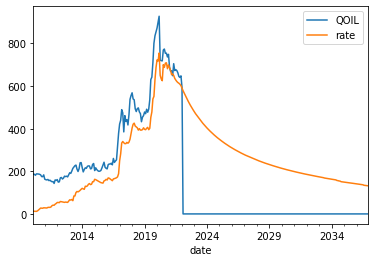

In [84]:
predict[['date','QOIL', 'rate']].groupby('date').agg('sum').plot()

## Участок анализ отклонений

In [85]:
predict.to_csv(f'decline_M_{str(w.value)}.csv')

In [57]:
os.getcwd()

'e:\\FOX_EXPORT\\АКС-МОКШ\\16.02.2022 14.05.12'

In [58]:
predict['dif'] = abs(predict['rate']-predict['QOIL'])

In [59]:
predict.reset_index(inplace=True, drop=True)

In [60]:
predict.groupby('well')['dif'].agg('mean').sort_values()#.hist(bins=100)

well
165А     0.091304
462А     0.192654
348А     0.246697
340А     0.302951
350      0.374979
179А     0.400112
466А     0.486844
1108Р    0.708813
338А     0.835242
415      1.844614
320А     1.923491
207А     2.101355
2813     2.436269
341А     2.571655
Name: dif, dtype: float64

### Участок с тестированием отдельных участков кода для функции

In [369]:
t = dca.get_time()
month = dca.get_time_monthly_vol()

In [370]:
well='10785'

In [371]:
data = df.loc[(df['well']==well)&(df['date']>'2012')&(df.status=='prod')]#, ['date', 'SOIL', 'QOIL']]

In [352]:
data

,№ скваж,Дата,Горизонт_x,Кол-во часов экспл всего по доб. скваж,"Добыча нефти за мес по скваж, т","Добыча воды за мес по скваж, т","Добыча воды за мес по скважине, м3",Кол-во часов работы всего по нагн. скваж,"Общая закачка всего по скваж за мес, м3",Горизонт_y,...,date,WCT,status,SBHPH,STHPH,SQLIQ,SWCT,SPROD,SOIL,PROD
17542,10785,2012-02-01,531.0,576.0,1.0,2.0,2.0,0.0,0.0,NaN,...,2012-02-01,0.666667,prod,128.342139,175.624573,1.039124,0.707095,0.021977,0.304365,NaN
17543,10785,2012-03-01,531.0,624.0,1.0,2.0,2.0,0.0,0.0,531.0,...,2012-03-01,0.666667,prod,126.361132,176.365249,0.958794,0.713118,0.019174,0.275061,0.002157
17544,10785,2012-04-01,531.0,600.0,1.0,2.0,2.0,0.0,0.0,NaN,...,2012-04-01,0.666667,prod,124.522950,176.797671,0.880607,0.719127,0.016846,0.247339,NaN
17545,10785,2012-05-01,531.0,624.0,1.0,2.0,2.0,0.0,0.0,NaN,...,2012-05-01,0.666667,prod,122.846306,176.944708,0.805209,0.724906,0.014884,0.221508,NaN
17546,10785,2012-06-01,531.0,600.0,1.0,22.0,21.0,0.0,0.0,531.0,...,2012-06-01,0.956522,prod,121.380174,176.882846,0.732810,0.730218,0.013203,0.197699,NaN
17547,10785,2012-07-01,531.0,624.0,2.0,59.0,56.0,0.0,0.0,531.0,...,2012-07-01,0.967213,prod,120.180154,176.712667,0.663405,0.734847,0.011735,0.175904,NaN
17548,10785,2012-08-01,531.0,624.0,1.0,2.0,2.0,0.0,0.0,531.0,...,2012-08-01,0.666667,prod,119.277019,176.527070,0.597134,0.738650,0.010430,0.156061,NaN
17549,10785,2012-09-01,531.0,600.0,1.0,2.0,2.0,0.0,0.0,NaN,...,2012-09-01,0.666667,prod,118.657495,176.385649,0.534442,0.741558,0.009258,0.138122,NaN
17550,10785,2012-10-01,531.0,624.0,1.0,5.0,4.0,0.0,0.0,531.0,...,2012-10-01,0.833333,prod,118.276026,176.309486,0.475849,0.743520,0.008200,0.122046,0.004070
17551,10785,2012-11-01,531.0,600.0,1.0,5.0,4.0,0.0,0.0,531.0,...,2012-11-01,0.833333,prod,118.063828,176.302057,0.421732,0.744483,0.007242,0.107760,NaN


In [372]:
float(data['QOIL'].tail(1).values)

0.0646900269541779

In [354]:
last_deb = data.loc[data['date']>data['date'].max(), 'QOIL']
last_deb

Series([], Name: QOIL, dtype: float64)

#### блок нормализации времени от начала работы скважины

In [355]:
data['Time'] = data['date']-data['date'].min()
data['Time'] = data['Time'] / np.timedelta64(1, "D")

<ipython-input-355-9a16526b44c0>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-355-9a16526b44c0>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Вот тут находим максимальный уровень добычи, чтобы от него начать падение отстраивать

In [356]:
shift = data.loc[data['QOIL']==data['QOIL'].max(), 'Time']
shift = int(shift.head(1).values)
shift

151

In [357]:
data['Time']=data['Time']-shift
sub=data.loc[data.Time>=0]
data['Time']=data['Time']+shift

<ipython-input-357-556fdff809bd>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-357-556fdff809bd>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [358]:
qi, Di = curve_fit(MH, sub['Time'], np.array(sub['QOIL']), bounds=(0, [100, 1, 1, 0.1]), method='trf')

In [359]:
qi[3]=qi[1]*qi[3]

In [360]:
qi

array([0.04336123, 0.0362901 , 0.99999752, 0.00181451])

['10852'] 943 [2.60751641e+00 1.00000000e-01 1.54890671e-06 3.50000000e-02] 0.6869829650959391\

In [361]:
mh = dca.MH(*qi)

In [362]:
q_mh = mh.rate(t)

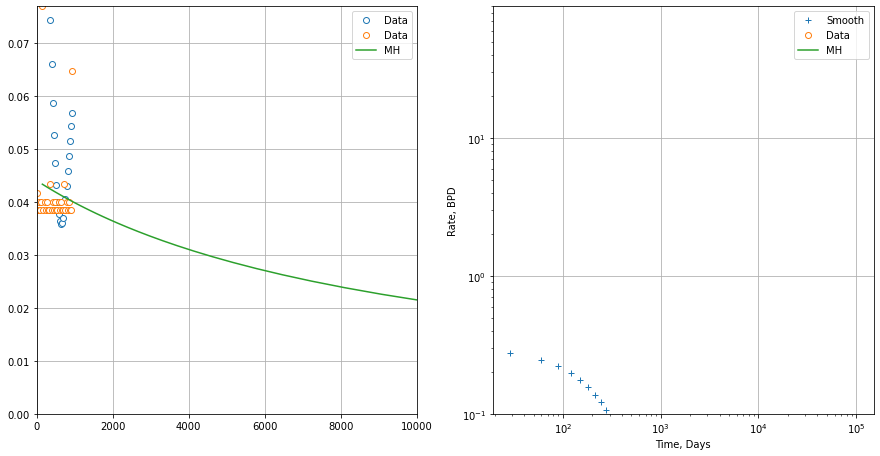

In [363]:
# Rate vs Time
fig = plt.figure(figsize=(15, 7.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(data['Time'], data['SOIL'], 'o', mfc='w', label='Data')
ax1.plot(data['Time'], data['QOIL'], 'o', mfc='w', label='Data')
#ax1.plot(t, q_thm, label='THM Transient')
#ax1.plot(t, q_trans, ls='--', label='THM Approx')
ax1.plot(t+shift, q_mh, label='MH')
#ax1.plot(t, q_ple, label='PLE')
#ax1.plot(t, q_se, label='SE')
#ax1.plot(t, q_dg, label='Duong')

#ax1.set(xscale='log', yscale='log', ylabel='Rate, BPD', xlabel='Time, Days')
ax1.set(ylim=(0, data['QOIL'].max()), xlim=(0, 1e4))
#ax1.set_aspect(1)
ax1.grid()
ax1.legend()

ax2.plot(data['Time'], data['SOIL'], '+', mfc='w', label='Smooth')
ax2.plot(data['Time'], data['QOIL'], 'o', mfc='w', label='Data')
#ax2.plot(t, q_thm, label='THM Transient')
#ax2.plot(t, q_trans, ls='--', label='THM Approx')
ax2.plot(t+shift, q_mh, label='MH')
#ax2.plot(t, q_ple, label='PLE')
#ax2.plot(t, q_se, label='SE')
#ax2.plot(t, q_dg, label='Duong')

ax2.set(xscale='log', yscale='log', ylabel='Rate, BPD', xlabel='Time, Days')
ax2.set(ylim=(1e-1, 9e1))#, xlim=(1e0, 1e5))
#ax2.set_aspect(1)
ax2.grid()
ax2.legend()


In [364]:
pred = pd.DataFrame(np.concatenate((sub.date, pd.date_range(sub.date.max(), periods=120, freq='MS'))))
pred.columns=['date']

In [365]:
pred['Time'] = pred['date']-pred['date'].min()
pred['Time'] = pred['Time'] / np.timedelta64(1, "D")

In [366]:
pred['rate'] = mh.rate(pred.Time)

In [367]:
pred['month_prod'] = mh.monthly_vol(pred.Time)

<AxesSubplot:>

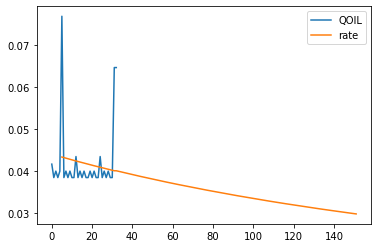

In [368]:
pd.merge(data, pred, left_on='date', right_on ='date', how='outer').loc[:,['QOIL', 'rate']].plot()#.iloc[100:,0]

In [272]:
pd.merge(data, pred, left_on='date', right_on ='date', how='outer')

,№ скваж,Дата,Горизонт_x,Кол-во часов экспл всего по доб. скваж,"Добыча нефти за мес по скваж, т","Добыча воды за мес по скваж, т","Добыча воды за мес по скважине, м3",Кол-во часов работы всего по нагн. скваж,"Общая закачка всего по скваж за мес, м3",Горизонт_y,...,STHPH,SQLIQ,SWCT,SPROD,SOIL,PROD,Time_x,Time_y,rate,month_prod
0,10852,2016-02-01,531.0,695.0,128.0,172.0,161.0,0.0,0.0,531.0,...,168.887216,10.006256,0.604899,0.155903,3.953483,NaN,0.0,NaN,NaN,NaN
1,10852,2016-03-01,531.0,724.0,146.0,161.0,151.0,0.0,0.0,NaN,...,168.872528,10.127875,0.611532,0.149737,3.934359,NaN,29.0,NaN,NaN,NaN
2,10852,2016-04-01,531.0,720.0,137.0,156.0,146.0,0.0,0.0,531.0,...,168.517501,10.245509,0.617554,0.144226,3.918358,NaN,60.0,NaN,NaN,NaN
3,10852,2016-05-01,531.0,605.0,108.0,175.0,163.0,0.0,0.0,531.0,...,167.935361,10.361948,0.623265,0.139671,3.903709,NaN,90.0,NaN,NaN,NaN
4,10852,2016-06-01,531.0,688.0,169.0,84.0,79.0,0.0,0.0,531.0,...,167.250771,10.479963,0.628919,0.136286,3.888911,NaN,121.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4625.0,0.001540,0.048102
182,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4656.0,0.001460,0.045623
183,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4686.0,0.001387,0.043345
184,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4717.0,0.001316,0.041111


In [536]:
pred

,date,Time,rate,month_prod
0,2020-03-01,0.0,1.605817,0.000000
1,2020-04-01,31.0,0.572623,29.073764
2,2020-05-01,61.0,0.283540,12.385621
3,2020-12-01,275.0,0.023218,0.794595
4,2020-12-01,275.0,0.023218,0.794595
...,...,...,...,...
119,2030-07-01,3774.0,0.000059,0.001825
120,2030-08-01,3805.0,0.000058,0.001789
121,2030-09-01,3836.0,0.000057,0.001755
122,2030-10-01,3866.0,0.000056,0.001722


In [32]:
df_new = pd.read_sql("select ngdu, god, mes, skw_id, t_rab, qnt_do, qn_ot from dbo.ot_dobf where ngdu=738", con=engine)

In [33]:
df_new

,ngdu,god,mes,skw_id,t_rab,qnt_do,qn_ot
0,738,2017,3,34099,743.0,2.795,2.903
1,738,2017,3,34101,744.0,8.540,7.884
2,738,2017,3,34102,641.9,12.049,12.517
3,738,2017,3,34106,742.2,2.686,2.480
4,738,2017,3,34108,743.0,14.697,13.569
...,...,...,...,...,...,...,...
16057,738,2021,8,48230,0.0,0.000,0.000
16058,738,2021,8,47854,0.0,0.000,0.000
16059,738,2021,8,50295,0.0,0.000,0.000
16060,738,2021,8,56790,0.0,0.000,0.000


In [ ]:
os